# part0: imports

In [59]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        reload(lstm)
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    print('Done')

Done


---

monkey population CCA plot

In [60]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [61]:
def remove_neurons(df, n_removed, signal):
    df_ = df.copy()
    n_neurons = df_[signal][0].shape[1]
    size = n_neurons - n_removed
    assert (size>0)

    mask = params.rng.choice(n_neurons, size, replace = False)
    df_[signal] = [arr[:, mask] for arr in df_[signal]]
    
    return df_

In [74]:
@utility.report
def plot_monkey_cca_subsample_neurons(ax, allDFs_MCx):

    #get pairs of sessions
    pairFileList_monkeys = []
    for I, df1 in enumerate(allDFs_MCx):
        for J, df2 in enumerate(allDFs_MCx):
            if J<=I or df1.monkey[0] == df2.monkey[0]: continue  # to repetitions
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue
            pairFileList_monkeys.append((I,J))
    
    #get data for neural modes
    side1df = [allDFs_MCx[i] for i,_ in pairFileList_monkeys]
    side2df = [allDFs_MCx[j] for _,j in pairFileList_monkeys]

    #successively remove neurons
    CC_corr_subsample = []
    n_iter = 10
    n_remove_per_iter = 5 
    for i in range(n_iter+1):
        signal = monkey_defs.areas[2] + '_rates'
        n_removed = i*n_remove_per_iter
        side1df_ = [remove_neurons(df, n_removed, signal) for df in side1df]
        side2df_ = [remove_neurons(df, n_removed, signal) for df in side2df]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            AllData1_monkey = dt.get_data_array(side1df_, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
            AllData2_monkey = dt.get_data_array(side2df_, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
            _,_, min_trials_monkey, min_time_monkey,_ = np.min((AllData1_monkey.shape,AllData2_monkey.shape),axis=0)

        CC_corr_monkey=[]
        #for each pair of sessions across monkeys
        for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_monkey,AllData2_monkey)):

            data1 = np.reshape(sessionData1[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData2[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
            k,l = pairFileList_monkeys[i]

            #perform CCA
            CC_corr_monkey.append((dt.canoncorr(data1, data2)[:4].mean()))
        CC_corr_monkey = np.array(CC_corr_monkey)
        CC_corr_subsample.append(CC_corr_monkey)
    
    # plotting
    x_ = np.arange(0, (n_iter+1)*n_remove_per_iter, n_remove_per_iter)

    utility.shaded_errorbar(ax, x_, np.array(CC_corr_subsample), color=params.colors.MainCC, marker = 'o')
    ax.set_xlabel('Number of dropped neurons')
    ax.set_ylabel('Canonical correlation')
    ax.set_ylim([0,1])
    ax.set_xlim([0, n_iter*n_remove_per_iter])
    # ax.legend(loc=(0,.8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))

    return CC_corr_subsample


Executed: `plot_monkey_cca_subsample_neurons` in 36.0s


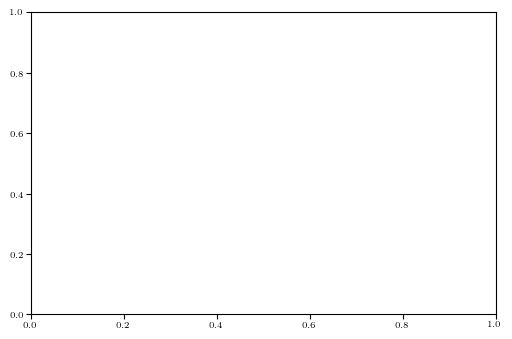

In [72]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()
    
    # _, allDFs_MCx = get_full_monkey_data()

    monkey_cc = plot_monkey_cca_subsample_neurons(ax, allDFs_MCx[10:15])
    plt.savefig(root / f'../figures/cca_subsample_neurons_monkey.pdf', format= 'pdf')


In [75]:
for df_ in allDFs_MCx:
    signal = 'MCx_rates'
    n_neurons = df_[signal][0].shape[1]
    print(n_neurons)

281
345
289
288
239
299
269
210
92
87
73
87
109
106
130
114
123
122
54
81
55
